# Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [0]:
import os
import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Activation, Flatten
from keras.regularizers import l1_l2

!nvidia-smi

Fri Jul 19 13:38:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

print(f' train data shape : {train_x.shape}')
print(f' train label shape : {train_y.shape}')
print(f' test data shape : {test_x.shape}')
print(f' test label shape : {test_y.shape}')

 train data shape : (50000, 32, 32, 3)
 train label shape : (50000, 1)
 test data shape : (10000, 32, 32, 3)
 test label shape : (10000, 1)


In [0]:
def preproc_x(x, flatten = False):
  x = x/255.0
  if flatten :
    x = x.reshape((len(x), -1))
  return x

def preproc_y(y, num_classes = 10):
  if y.shape[-1] == 1 :
    y = keras.utils.to_categorical(y, num_classes)
  return y

In [0]:
train_x = preproc_x(train_x)
test_x = preproc_x(test_x)

train_y = preproc_y(train_y)
test_y = preproc_y(test_y)

In [0]:
#Using Dropout and BatchNormalization to do the regularization
def build_model(input_shape, output_units = 10):
  
  input_layer = keras.layers.Input(input_shape)
  
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same') (input_layer)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same') (x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same') (x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same') (x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  
  x = Flatten()(x)
  
  x = Dense(units = 512)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(units = 256)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(units = 128)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  
  output_layer = Dense(units = output_units, activation = 'softmax')(x)
  
  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  
  return model

In [0]:
batch_size = 128
epochs = 50

In [0]:
results = {}

model = build_model(train_x.shape[1:], 10)
model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])
model.summary()

history = model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, shuffle = True, validation_data = [test_x, test_y])

name_tag = "Dropout_NB"
results[name_tag] = {
    'train_loss' : history.history['loss'],
    'valid_loss' : history.history['val_loss'],
    'train_acc' : history.history['acc'],
    'valid_acc' : history.history['val_acc']
}


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_35 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_36 (Activation)   (None, 32, 32, 64)        0         
__________

In [0]:
#Using l1_l2 regularizer and BatchNormalization
def build_model2(input_shape, output_units):
  
  input_layer = keras.layers.Input(input_shape)
  regularizer = l1_l2(l1 = 1e-4 , l2 = 1e-6)
  
  
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', kernel_regularizer = regularizer) (input_layer)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', kernel_regularizer = regularizer) (x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', kernel_regularizer = regularizer) (x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', kernel_regularizer = regularizer) (x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  
  x = Flatten()(x)
  
  x = Dense(units = 512, kernel_regularizer = regularizer)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dense(units = 256, kernel_regularizer = regularizer)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dense(units = 128, kernel_regularizer = regularizer)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  output_layer = Dense(units = output_units, activation = 'softmax')(x)
  
  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  return model

In [0]:
model = build_model2(train_x.shape[1:], 10)
model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])
model.summary()

history = model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, shuffle = True, validation_data = [test_x, test_y])

name_tag = "Regularizer_NB"
results[name_tag] = {
    'train_loss' : history.history['loss'],
    'valid_loss' : history.history['val_loss'],
    'train_acc' : history.history['acc'],
    'valid_acc' : history.history['val_acc']
}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_57 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_56 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_58 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_57 (Activation)   (None, 32, 32, 64)        0         
__________

In [0]:
#Using l1_l2 regularizer and Dropout
def build_model3(input_shape, output_units):
  
  input_layer = keras.layers.Input(input_shape)
  regularizer = l1_l2(l1 = 1e-4 , l2 = 1e-6)
  
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = regularizer)(input_layer)
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = regularizer)(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = regularizer)(x)
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = regularizer)(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  
  x = Flatten()(x)
  x = Dense(units = 512, activation = 'relu', kernel_regularizer = regularizer)(x)
  x = Dropout(0.25)(x)
  x = Dense(units = 256, activation = 'relu', kernel_regularizer = regularizer)(x)
  x = Dropout(0.25)(x)  
  x = Dense(units = 128, activation = 'relu', kernel_regularizer = regularizer)(x)
  x = Dropout(0.25)(x)  
  
  output_layer = Dense(units = output_units, activation = 'softmax')(x)
  
  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  return model

In [0]:
model = build_model3(train_x.shape[1:], 10)
model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])
model.summary()

history = model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, shuffle = True, validation_data = [test_x, test_y])

name_tag = "Regularizer_Dropout"
results[name_tag] = {
    'train_loss' : history.history['loss'],
    'valid_loss' : history.history['val_loss'],
    'train_acc' : history.history['acc'],
    'valid_acc' : history.history['val_acc']
}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 16, 16, 32)        9248      
__________

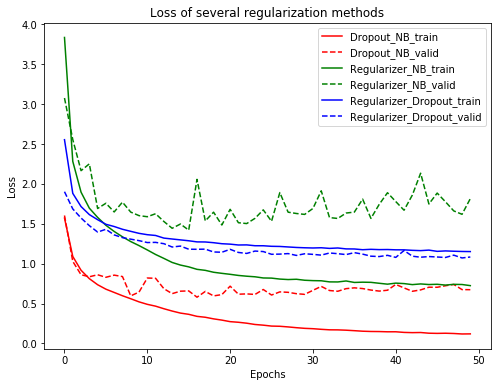

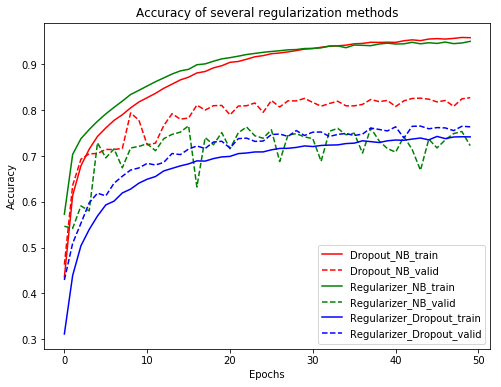

In [0]:
import matplotlib.pyplot as plt

colors = ['r','g','b','y','k','m']

plt.figure(figsize = (8,6))
for i, cond in enumerate(results.keys()):
  plt.plot(results[cond]['train_loss'], '-',label = cond + "_train", color = colors[i])
  plt.plot(results[cond]['valid_loss'], '--', label = cond + "_valid", color = colors[i])
  
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss of several regularization methods')
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
for i, cond in enumerate(results.keys()):
  plt.plot(results[cond]['train_acc'],'-', label = cond + "_train", color = colors[i])
  plt.plot(results[cond]['valid_acc'],'--', label = cond + "_valid", color = colors[i])
  
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of several regularization methods')
plt.legend()
plt.show()